In [1]:
# coding='utf-8'
# Imports
from bs4 import BeautifulSoup
from matplotlib.ticker import FuncFormatter
import csv
import errno
import json
import locale
import matplotlib.pyplot as plt
import operator
import os
import pandas as pd

import rotinas as rtn

"""Lê dados de parlamentares de arquivos CSV e
gera gráficos, texto e páginas com o conteúdo
"""

locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

# Lê legislatura e Lista de anos de mandato para contabilização
with open('../csv/anos.csv', newline='') as arquivoAnos:
    anosReader = csv.reader(arquivoAnos)
    for row in anosReader:
        # Ignora o header (se houver)
        if rtn.maiorQue(row[0]) and rtn.maiorQue(row[1]) and rtn.maiorQue(row[2]):
            legislaturaAtual = int(row[0])
            anos = list(range(int(row[1]), int(row[2]) + 1))
            break

# Lê créditos das fotos
# Ao fim, listaCredito[codigo] = credito para senador[codigo]
with open('../csv/creditos.csv', newline='') as creditos:
    creditosReader = csv.reader(creditos)
    header = next(creditosReader)
    listaCredito = {}
    for row in creditosReader:
        listaCredito[int(row[0].split('.')[0].replace('senador', ''))] = row[1]

# Lê DataFrames
dadosSenado = pd.read_csv('../csv/senado.csv', encoding='utf-8')
top = pd.read_csv('../csv/top.csv', encoding='utf-8')
gastoPartidos = pd.read_csv('../csv/gastoPartidos.csv',
                            encoding='utf-8', index_col=0)
gastoEstados = pd.read_csv('../csv/gastoEstados.csv',
                           encoding='utf-8', index_col=0)
#sexo = pd.read_csv('csv/sexo.csv', encoding='utf-8')
sexo = dadosSenado.rename(columns={'Participacao': '(Sexo, Situação)'}).groupby(
    ['sexo', 'status'])['(Sexo, Situação)'].count()
sexoT = pd.read_csv('../csv/sexoT.csv', encoding='utf-8', index_col=0)

# Lê arquivo json
with open('../json/gastosSenadores.json', 'r', encoding='utf-8') as entrada:
    gastosSenadores = json.load(entrada)

# Calcula dados importantes
totalSenadores = len(dadosSenado)
totalHomens = len(dadosSenado[dadosSenado.sexo == 'Masculino'])
totalMulheres = len(dadosSenado[dadosSenado.sexo == 'Feminino'])
totalExercicio = len(dadosSenado[dadosSenado.status == 'Exercicio'])
totalMulheresExercicio = dadosSenado.query(
    'sexo == "Feminino" and status == "Exercicio"').count()[0]
totalForaExercicio = len(dadosSenado[dadosSenado.status == 'ForaExercicio'])
totalGasto = dadosSenado['gastos'].sum()

# Não contabiliza parlamentares que ainda não efetuaram gastos no cálculo de médias
gastoMedioSenadores = dadosSenado.query('gastos != 0')['gastos'].mean()
mediaGastosHomensExercicio = dadosSenado.query(
    'gastos != 0 and sexo == "Masculino" and status == "Exercicio"')['gastos'].mean()
mediaGastosMulheresExercicio = dadosSenado.query(
    'gastos !=0 and sexo == "Feminino" and status == "Exercicio"')['gastos'].mean()


# Imprime algumas informações do senado, pelos dados coletados
print('Há no senado {:d} senadores, distribuidos entre {:d} homens e {:d} mulheres'.format(
    totalSenadores, totalHomens, totalMulheres))
print('As mulheres representam ' + locale.format('%.2f',
                                                 totalMulheres / totalSenadores * 100) + '% do total')
print('Há {:d} senadores em exercício, destes {:d} são mulheres'.format(
    totalExercicio, totalMulheresExercicio))
print('As mulheres representam ' + locale.format('%.2f',
                                                 totalMulheresExercicio / totalExercicio * 100) + '% deste total')
print('O gasto médio de senadores homens em exercício foi de ' +
      rtn.reais(mediaGastosHomensExercicio))
print('O gasto médio de senadores mulheres em exercício foi de ' +
      rtn.reais(mediaGastosMulheresExercicio))
print('O gasto médio dos senadores, em exercício e fora de exercício, foi de ' +
      rtn.reais(gastoMedioSenadores))
print('O montante de despesas parlamentares em {:d} anos foi de {}, com media anual de {}\n'.format(
    len(anos), rtn.reais(totalGasto), rtn.reais(totalGasto / len(anos))))

# Totaliza os gastos do senado por tipo de gasto
gastosSenado = {}
for senador in gastosSenadores:
    for gastos in senador['gastos']:
        for caput in gastos['lista']:
            if not caput in gastosSenado:
                gastosSenado[caput] = gastos['lista'][caput]
            else:
                gastosSenado[caput] += gastos['lista'][caput]

print("Gastos do senado por tema:")
totalizacaoGastosSenado = 0.0
for caput in gastosSenado:
    totalizacaoGastosSenado += gastosSenado[caput]
    print('{}: {}'.format(caput, rtn.reais(round(gastosSenado[caput], 2))))

print('Total de gastos: {}'.format(rtn.reais(round(totalizacaoGastosSenado, 2))))

# Gera página HTML


def geraModeloHTML(modeloHtml, saida):
    """Gera página HTML a partir de um modelo (modeloHtml)
    não retorna nenhum valor
    """
    def totalBeneficioMoradia(senador):
        """Calcula o total do beneficio moradia de um senador
        """
        am = 'Auxílio-Moradia-'
        im = 'Imóvel Funcional-'
        total = 0
        for ano in anos:
            total += senador[am + str(ano)] + senador[im + str(ano)]
        return total

    def htmlRowsSenado(senadores, anoConsulta):
        """Gera string com linhas da tabela html de uma lista de senadores
        na rotina a identação é "hardcoded"... Poderia não haver identação.
        """
        i = 1
        textoMes = {True: "mês", False: "meses"}
        html = ""
        for index, senador in senadores.iterrows():
            html += "{:<12}<tr>\n".format('')
            html += "{:<14}<td>{}</td>\n".format('', i)
            html += "{:<14}<td align='middle'><a href='{}' target='_blank'><img src='fotos/senador{}.jpg' height='51' width='42'><span class='fototip'>Crédito foto: {}</span></a></td>\n".format(
                '', f"http://www6g.senado.leg.br/transparencia/sen/{senador['codigo']}/?ano={anoConsulta}", senador['codigo'], listaCredito[senador['codigo']])
            html += "{:<14}<td align='left'>{}</td>\n".format(
                '', senador['nome'])
            html += "{:<14}<td align='left' class='gastos' name='{}'>{}</td>\n".format(
                '', senador['codigo'], rtn.reais(senador['gastos']))
            html += "{:<14}<td align='left'>{}</td>\n".format(
                '', senador['Participacao'])
            html += "{:<14}<td align='middle'>{}</td>\n".format(
                '', senador['UF'])
            html += "{:<14}<td align='left'>{}</td>\n".format(
                '', senador['partido'])
            html += "{:<14}<td align='right'>{} pessoas</td>\n".format(
                '', senador['TotalGabinete-2017'])
            beneficioMoradia = totalBeneficioMoradia(senador)
            html += "{:<14}<td align='right'>{} {}</td>\n".format(
                '', beneficioMoradia, textoMes[beneficioMoradia == 1])
            html += "{:<12}</tr>\n".format('')
            i += 1
        return html

    def exercicio():
        """Lista de senadores em exercício, em ordem alfabética de nome
        """
        return htmlRowsSenado(dadosSenado.query('status == "Exercicio"').sort_values(by='nomeSort'), 2017)

    def foraExercicio():
        """Lista de senadores fora de exercício, em ordem alfabética de nome
        """
        return htmlRowsSenado(dadosSenado.query('status == "ForaExercicio"').sort_values(by='nomeSort'), 2017)

    def caption(mensagem):
        html = "{:<10}<caption>Senadores {} - {}/{}</caption>\n".format(
            '', mensagem, anos[0], anos[len(anos) - 1])
        return html

    def captionExercicio():
        return caption("em Exercício")

    def captionForaExercicio():
        return caption("fora de Exercício")

    def tituloLegislatura():
        html = '{:<6}<div class="row"><b class="SenadoTitle">BRASIL - {}ª Legislatura</b><br></div>\n'.format(
            '', legislaturaAtual)
        return html

    # Dicionário de padrões a encontrar e função que será chamada para cada padrão
    padrao = {"<!--Exercicio-->": exercicio,
              "<!--ForaExercicio-->": foraExercicio,
              "<!--CaptionExercicio-->": captionExercicio,
              "<!--CaptionForaExercicio-->": captionForaExercicio,
              "<!--TituloLegislatura-->": tituloLegislatura}

    # Le arquivo de entrada e inclui o texto gerado de acordo com o padrão encontrado
    for linha in modeloHtml:
        # a linha com o marcador de padrão é mantida (se assume que é um comentário html)
        saida.write(linha)
        if linha.strip() in padrao:
            saida.write(f"{padrao[linha.strip()]()}")
    modeloHtml.close()
    saida.close()


# Abre os arquivos e gera a página HTML
try:
    modeloHtml = open("../index.tmpl", "r")
    try:
        # Se conseguiu abrir entrada, tenta abrir saída e gerar modelo
        saida = open("../index.html", "w")
        geraModeloHTML(modeloHtml, saida)
    except FileNotFoundError:
        # trata erros na abertura do arquivo de saída
        modeloHtml.close()
        print("Erro no nome do arquivo de saída")
    except IOError:
        modeloHtml.close()
        print("Não consigo criar index.html")
except IOError:
    # Trata erro na abertura do arquivo de entrada
    print("Não consigo abrir index.tmpl")

Há no senado 118 senadores, distribuidos entre 104 homens e 14 mulheres
As mulheres representam 11,86% do total
Há 81 senadores em exercício, destes 13 são mulheres
As mulheres representam 16,05% deste total
O gasto médio de senadores homens em exercício foi de R$ 1.029.989,48
O gasto médio de senadores mulheres em exercício foi de R$ 989.322,60
O gasto médio dos senadores, em exercício e fora de exercício, foi de R$ 864.313,71
O montante de despesas parlamentares em 3 anos foi de R$ 89.888.625,68, com media anual de R$ 29.962.875,23

Gastos do senado por tema:
Aluguel de imóveis para escritório político: R$ 14.623.620,04
Aquisição de material de consumo: R$ 2.685.076,20
Locomoção, hospedagem, alimentação, combustíveis e: R$ 17.060.761,39
Divulgação da atividade parlamentar: R$ 10.224.987,27
Passagens aéreas, aquáticas e terrestres nacionais: R$ 19.496.527,15
Diárias: R$ 1.917.341,92
Combustíveis: R$ 1.644.514,97
Outros materiais: R$ 1.120.436,39
Correios: R$ 9.096.779,89
Contratação d

In [2]:
%matplotlib inline

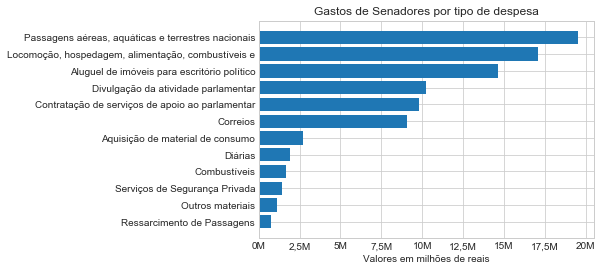

In [3]:
# Gera gráficos
imagens = 'imagens'
if not os.path.exists(imagens):
    os.makedirs(imagens)


plt.style.use('seaborn-whitegrid')


def tickReais(x, pos=None):
    """Retorna uma string no formato <numero>M para ser usada
    em gráficos
    """
    if x == int(x):
        formato = '%d'
    else:
        formato = '%.1f'
    return locale.format(formato, x, grouping=True) + 'M'


# Ordena os tipos de gasto pelo montante e cria os vetores
# de título (caput), dados
gS = sorted(gastosSenado.items(), key=operator.itemgetter(1))
caput = []
y = []
x = []
i = 0
for item in gS:
    caput.append(item[0])
    x.append(item[1] / 1000000)
    y.append(i)
    i += 1

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots()
ax.barh(y, x, tick_label=caput)
ax.set(xlabel='Valores em milhões de reais',
       title='Gastos de Senadores por tipo de despesa')
ax.xaxis.set_major_formatter(FuncFormatter(tickReais))
#fig.savefig(f"{imagens}/gastosSenado.png",
#            transparent=False, bbox_inches="tight")

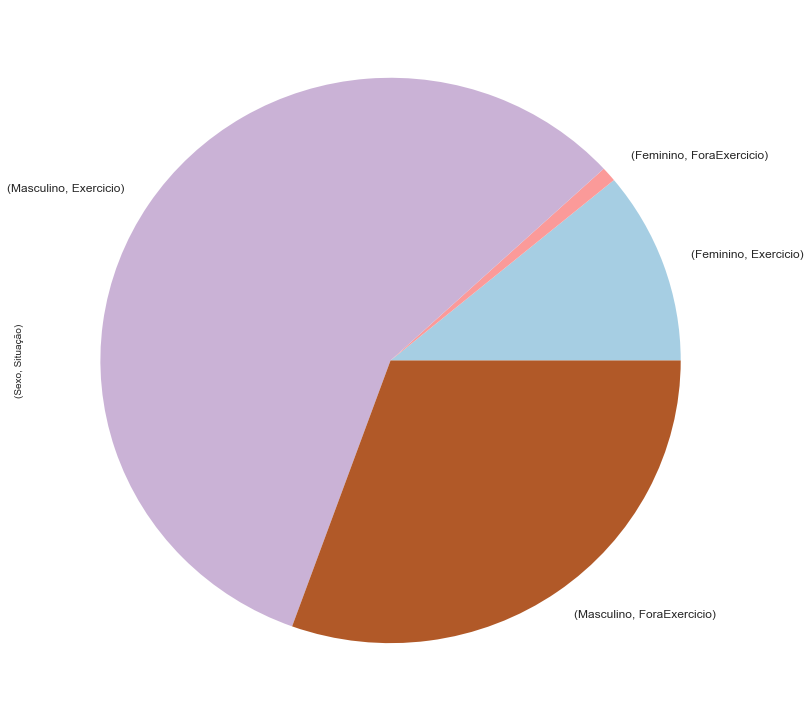

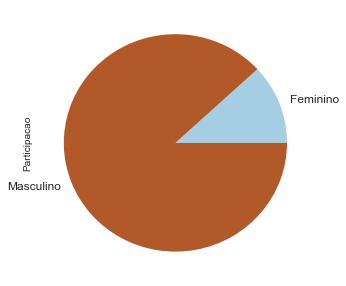

In [4]:
gSexo = sexo.plot(kind='pie', figsize=(13, 13), fontsize=12,
                  subplots=True, legend=False, colormap='Paired')
#gSexo[0].get_figure().savefig(f"{imagens}/distSexo.png")

gSexoT = sexoT[['Participacao']].plot(kind='pie', figsize=(
    5, 5), subplots=True, legend=False, fontsize=12, colormap='Paired')
#gSexoT[0].get_figure().savefig(f"{imagens}/distSexoT.png")

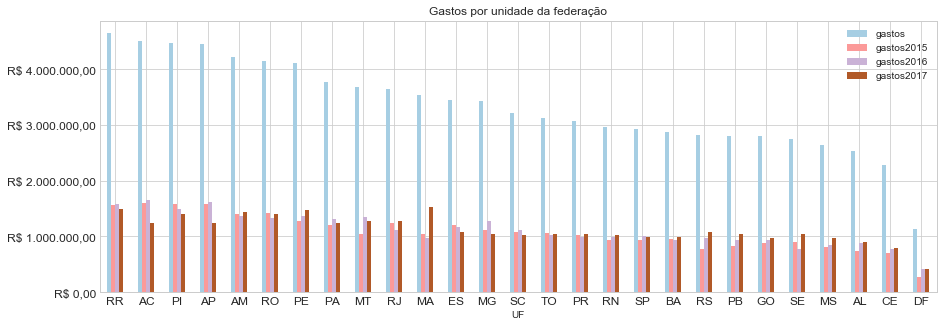

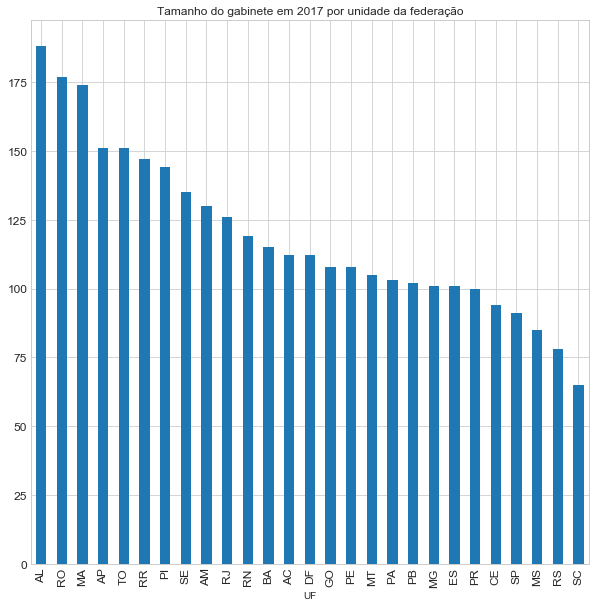

In [5]:
gEstados = gastoEstados[['gastos', 'gastos2015', 'gastos2016', 'gastos2017']].plot(
    kind='bar', rot=0, title='Gastos por unidade da federação', figsize=(15, 5), legend=True, fontsize=12, colormap='Paired')
gEstados.yaxis.set_major_formatter(FuncFormatter(rtn.reais))
#gEstados.get_figure().savefig(f"{imagens}/gastoEstados.png")

gabineteEstados = gastoEstados.sort_values(by=['TotalGabinete-2017'], ascending=False)[['TotalGabinete-2017']].plot(
    kind='bar', title='Tamanho do gabinete em 2017 por unidade da federação', figsize=(10, 10), fontsize=12, legend=False)
#gabineteEstados.get_figure().savefig(
#    f"{imagens}/gastoGabineteEstados-2017.png")

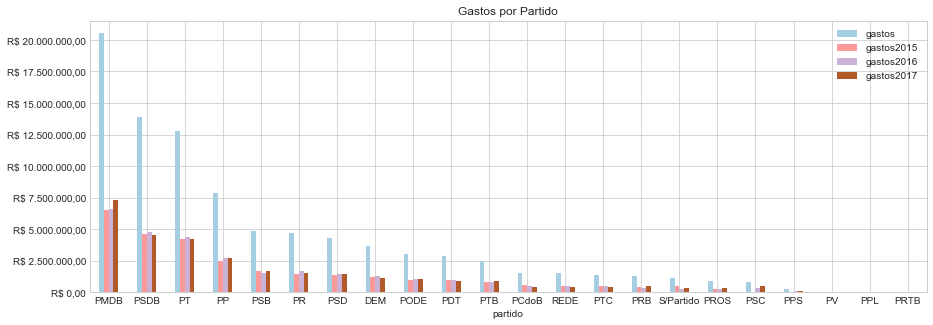

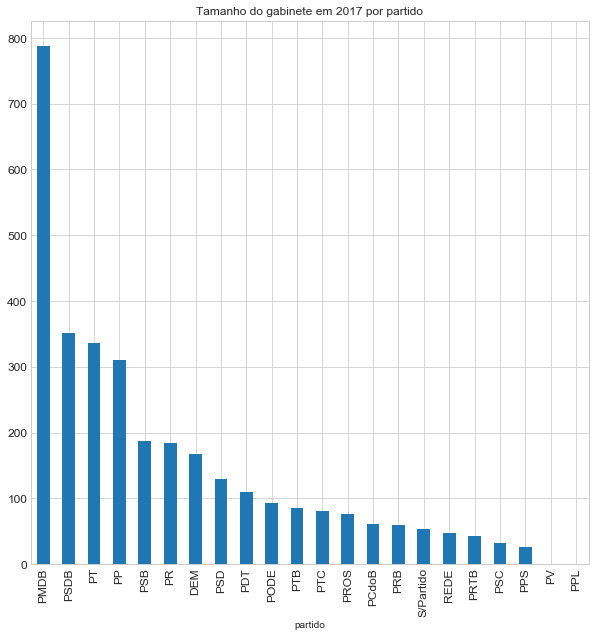

In [6]:
gPartidos = gastoPartidos[['gastos', 'gastos2015', 'gastos2016', 'gastos2017']].plot(
    kind='bar', rot=0, title='Gastos por Partido', figsize=(15, 5), legend=True, fontsize=10, colormap='Paired')
gPartidos.yaxis.set_major_formatter(FuncFormatter(rtn.reais))
#gPartidos.get_figure().savefig(f"{imagens}/gastoPartidos.png")

gabinetePartidos = gastoPartidos.sort_values(by=['TotalGabinete-2017'], ascending=False)[['TotalGabinete-2017']].plot(
    kind='bar', title='Tamanho do gabinete em 2017 por partido', figsize=(10, 10), fontsize=12, legend=False)
#gabinetePartidos.get_figure().savefig(
#    f"{imagens}/gastoGabinetePartidos-2017.png")

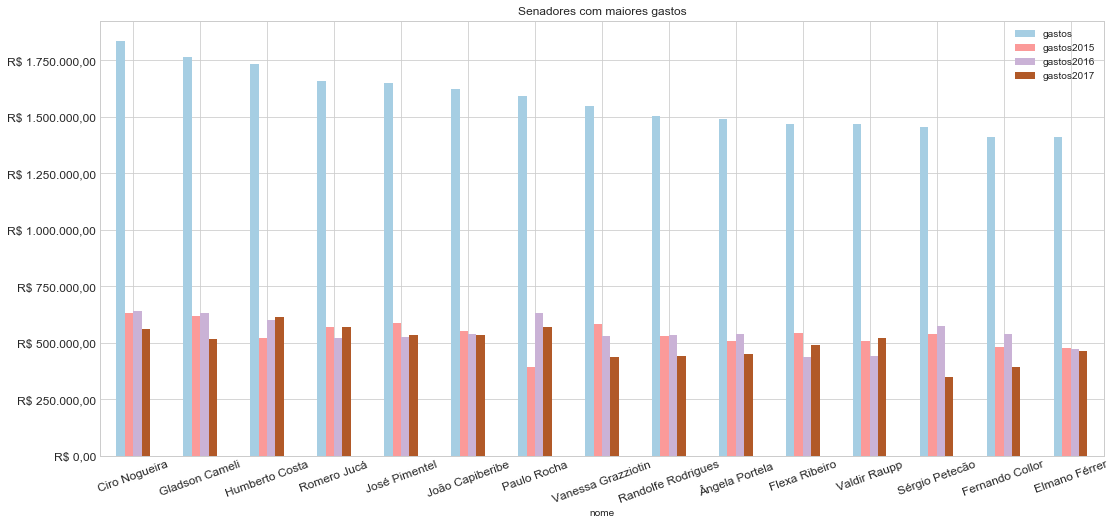

In [7]:
gTop = top[['gastos', 'gastos2015', 'gastos2016', 'gastos2017']].plot(
    kind='bar', rot=20, title='Senadores com maiores gastos', x=top['nome'], figsize=(18, 8), legend=True, fontsize=12, colormap='Paired')
gTop.yaxis.set_major_formatter(FuncFormatter(rtn.reais))
#gTop.get_figure().savefig(f"{imagens}/maiores.png")

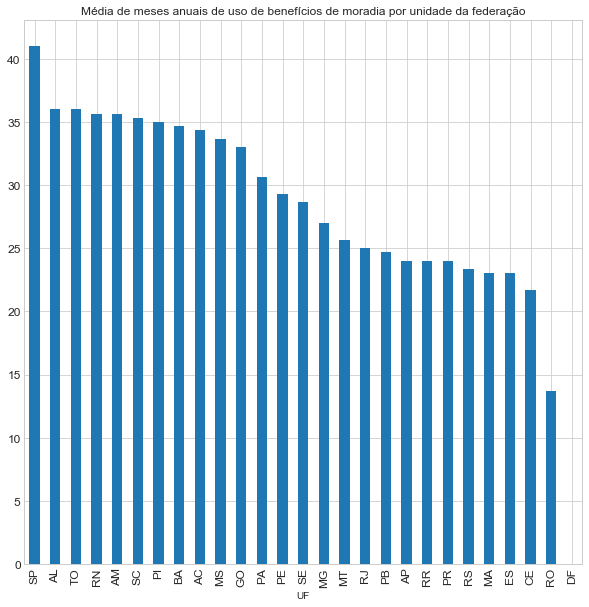

In [8]:
beneficioMoradia = (gastoEstados['Auxílio-Moradia-2015'] + gastoEstados['Auxílio-Moradia-2016'] + gastoEstados['Auxílio-Moradia-2017'] +
                    gastoEstados['Imóvel Funcional-2015'] +
                    gastoEstados['Imóvel Funcional-2016'] +
                    gastoEstados['Imóvel Funcional-2017']) / len(anos)
gBeneficio = beneficioMoradia.sort_values(ascending=False).plot(
    kind='bar', title='Média de meses anuais de uso de benefícios de moradia por unidade da federação', figsize=(10, 10), fontsize=(12), legend=False)
#gBeneficio.get_figure().savefig(f"{imagens}/moradiaEstado.png")